In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

from xj_utilities import *# save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'

# save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
# fun_create_folder(save_folder_path=save_folder_path)

/shared/MouseBrainAtlasXiang/utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist

Setting environment for AWS compute node


Cannot import mxnet.


In [2]:
scan_parameters = {}

In [3]:
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
# Paremters for image reconstruction
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True

scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness','label','major_axis_length','minor_axis_length']
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity']
if 'moments_hu' in scan_parameters['prop_for_comparison']:
    scan_parameters['compare_weight'] = [1 for i in range(6 + len(scan_parameters['prop_for_comparison']))]
else:
    scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.9
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']
scan_parameters['scan_outside_margin'] = 1000
stack = scan_parameters['stack']

In [142]:
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity','orientation','compactness']
scan_parameters['compare_weight'] = [5,2.5,1,1.5]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))


In [4]:
scan_parameters['secList'] = fun_get_valid_section_list(stack=stack)

In [5]:
# Whole image setting:
scan_parameters['crop_0_min'] = 0
scan_parameters['crop_1_min'] = 0
scan_parameters['crop_0_max'] = scan_parameters['oriImL0']
scan_parameters['crop_1_max'] = scan_parameters['oriImL1']
scan_parameters['crop_range_mmxx'] = (scan_parameters['crop_0_min'], scan_parameters['crop_1_min'], scan_parameters['crop_0_max'], scan_parameters['crop_1_max'])
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']

In [6]:
# margin = 10
# bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
# bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# # bbox_7N = bboxs_7N[154]
# scan_parameters['crop_range_mmxx'] = bbox_7N
# scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
# scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
# scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
# scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

### Generate grid

In [7]:
patch_size = scan_parameters['patch_size'];
patch_half_size = patch_size / 2;
stride = scan_parameters['stride'];
input_image_1 = scan_parameters['oriImL1'];
input_image_0 = scan_parameters['oriImL0'];

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, input_image_0,input_image_1))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

### Reconstruct images

In [8]:
section = 152
cell_global_coord = {}
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
cell_centroids = {}
cell_numbers = {}
fun_mmxx_to_mxmx
scan_range = scan_parameters['scan_section_range']
secList = scan_parameters['secList'] 
sec_load_data_list = range(section - scan_range, section + scan_range + 1)
scan_section = list(sec_load_data_list)
scan_section.remove(section)
tempList = list(sec_load_data_list)
for tempSec in tempList:
    if tempSec in secList:
        cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
        temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                    oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
#             im_label[tempSec] = temp_im_label
#             im_BW[tempSec] = temp_im_label > 0
        im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
    else:
        sys.stderr.write('Warning: missing section %d'%tempSec)
        scan_section.remove(tempSec)
        sec_load_data_list.remove(tempSec)

### Eliminate small blobs

In [9]:
blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
    (blob_prop_dic[tempSec]['compactness']>0,
#      blob_prop_dic[tempSec]['compactness']<2.5,
     blob_prop_dic[tempSec]['area']<3000,
     blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}  

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
secList_in_BlobPropDic = im_blob_prop.keys()
if set(scan_section).issubset(set(secList_in_BlobPropDic)):
    pass
else:
    print('Warrning: Scaned section(s) not included in input im_blob_prop')

### Update labeled images 

In [10]:
blob_selected_coord = {tmpSec:[tmpProp['coords'] for tmpProp in im_blob_prop[tmpSec][blob_idx_selection[tmpSec]]] for tmpSec in sec_load_data_list }
for tmpSec in sec_load_data_list:
    temp_im_label, temp_im_blob_prop,_ = fun_reconstruct_labeled_image(blob_selected_coord[tmpSec], crop_range=scan_parameters['crop_range_mxmx'],oriImL0=scan_parameters['oriImL0'], oriImL1=scan_parameters['oriImL1']);
    im_label[tmpSec] = temp_im_label
    im_blob_prop[tmpSec] = np.array(temp_im_blob_prop)

blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
secList_in_BlobPropDic = im_blob_prop.keys()


### Compute similarity dataset

In [143]:
# Initialization
scan_range = scan_parameters['scan_section_range']
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']
prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']
compare_weight = scan_parameters['compare_weight']
o_scan_size = scan_parameters['scan_size'] 

In [165]:
# Look at the next section
tempSec = scan_section[1]
num_patch = len(patch_center_pixel_location);
patchID = 9832;
patch_scan_range = 1;

In [166]:
np.where(patch_map == patchID)

(array([72]), array([112]))

In [167]:
current_blobID_list = np.unique(fun_crop_images_2dInput(im_label[section], contour=patch_contour[patchID], im0max=im0max, im1max=im1max)).tolist()
assert 0 in current_blobID_list, current_blobID_list.remove(0)
num_current_blob = len(current_blobID_list);

In [168]:
# Given patchID in section section, get the scan_patchID_list in section tempSec
patch_loc = patch_center_pixel_location/ stride - patch_half_size/stride;
patch_map = np.zeros(np.max(patch_center_pixel_location/ stride - 1, axis=0),dtype=np.int16)
for tmpIdx in range(len(patch_loc)):
    tmpX = patch_loc[tmpIdx][0];
    tmpY = patch_loc[tmpIdx][1];
    patch_map[tmpX, tmpY] = tmpIdx
patch_map_0, patch_map_1 = np.shape(patch_map)
# Get scan patch index
temp_next_sec_range, _ = fun_scan_range(patch_loc[patchID], patch_scan_range, im0max=patch_map_0, im1max=patch_map_1)
scan_patchID_list = fun_crop_images(patch_map, *temp_next_sec_range, im0max=patch_map_0, im1max=patch_map_1).flatten()

In [169]:
# # scan_patchID = scan_patchID_list[0]
# scan_patchID = 4000
# # Get blob props in patches by pologen. Alternatively, can use crop image, but require storing the image in the RAM
# tempBlobInside scan_patchID = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],patch_contour[scan_patchID],coor_order='cr')
# tempBlobInsideIndex = np.where(tempBlobInside)[0]
# temp_num_blob = len(tempBlobInsideIndex)
# temp_weight_sim_matrix = np.zeros([num_current_blob, temp_num_blob], dtype=np.float16)
# for tmp_current_blobID_idx in range(len(current_blobID_list)):
#     temp_curr_dablob_props = {}
#     for tempProp in prop:
#         temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][current_blobID_list[tmp_current_blobID_idx]]

#     if temp_num_blob:
#         temp_sim = {}
#         for temp_prop in prop_for_comparison:
#               temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
#         temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))
#         temp_weight_sim_matrix[tmp_current_blobID_idx,:] = np.dot(temp_sim_matrix,compare_weight)

In [170]:
# Score map: single patch vs whole images
score_map = np.zeros(np.shape(patch_map))
avg_score_map = np.zeros(np.shape(patch_map))
for scan_patchID in range(len(patch_loc)):
    tempBlobInside = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],patch_contour[scan_patchID],coor_order='cr')
    tempBlobInsideIndex = np.where(tempBlobInside)[0]
    temp_num_blob = len(tempBlobInsideIndex)
    temp_weight_sim_matrix = np.zeros([num_current_blob, temp_num_blob], dtype=np.float16)
    for tmp_current_blobID_idx in range(len(current_blobID_list)):
        temp_curr_blob_props = {}
        for tempProp in prop:
            temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][current_blobID_list[tmp_current_blobID_idx]]

        if temp_num_blob:
            temp_sim = {}
            for temp_prop in prop_for_comparison:
                  temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
            temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))
            temp_weight_sim_matrix[tmp_current_blobID_idx,:] = np.dot(temp_sim_matrix,compare_weight)
    score_map[tuple(patch_loc[scan_patchID])] = fun_region_similarity_v1(temp_weight_sim_matrix)
    avg_score_map[tuple(patch_loc[scan_patchID])] = fun_region_similarity_v2(temp_weight_sim_matrix)
        

In [225]:
vis_map = score_map.copy()
avg_vis_map = avg_score_map.copy()

In [173]:
np.where(patch_map ==  patchID)

(array([72]), array([112]))

In [222]:
vis_map = np.power(vis_map,2)

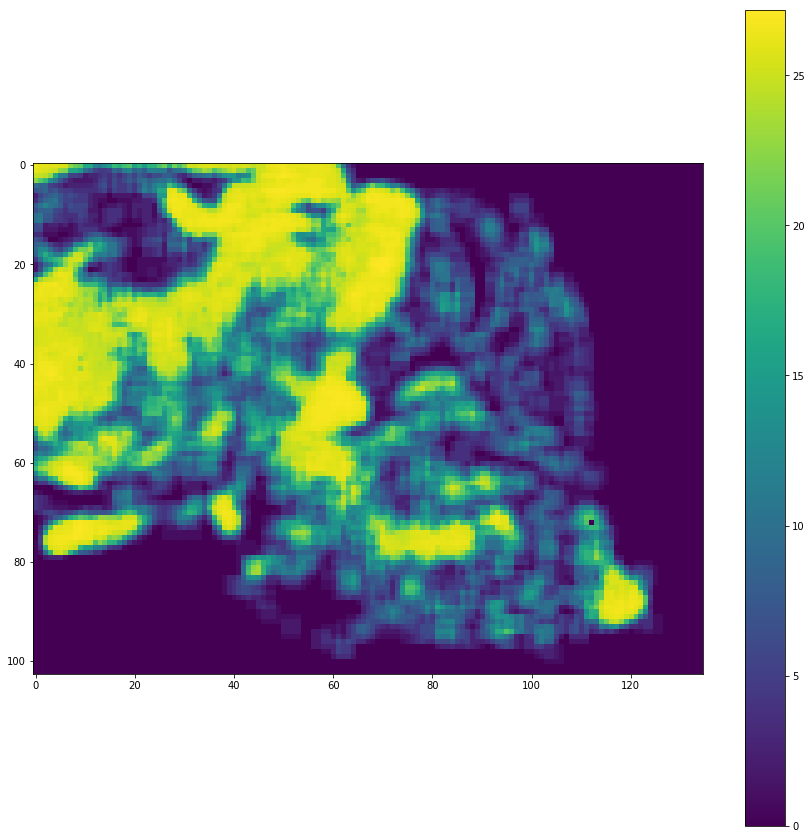

In [227]:
vis_map[72,112] = 0;
plt.figure(figsize=(15,15))
plt.imshow(vis_map);
plt.colorbar()

In [130]:
avg_vis_map = np.power(avg_vis_map,2)

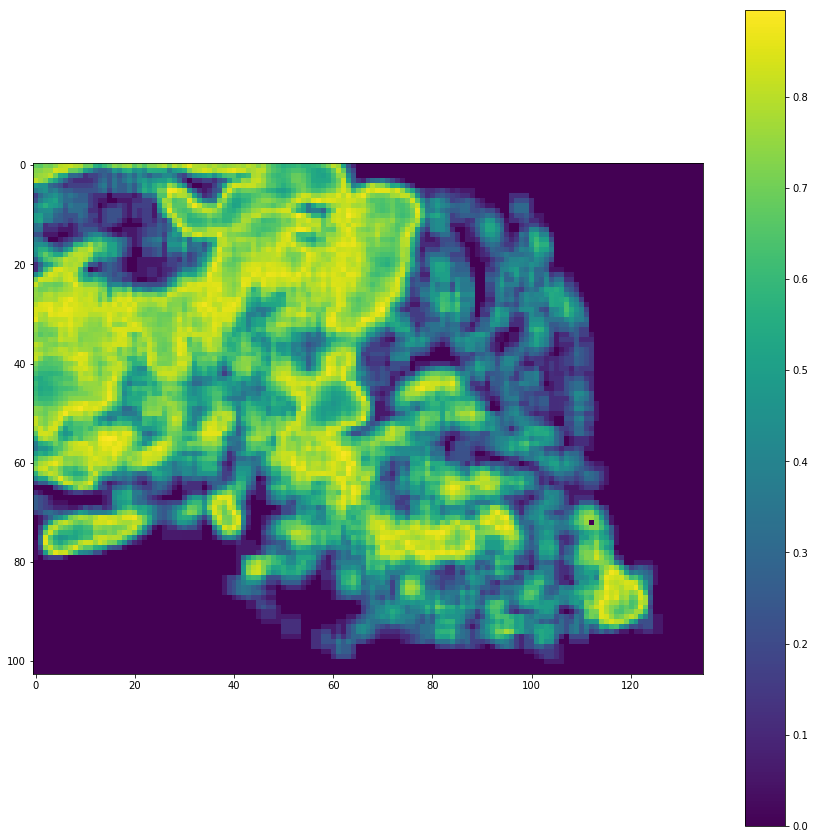

In [175]:
avg_vis_map[72,112] = 0;
plt.figure(figsize=(15,15))
plt.imshow(avg_vis_map)
plt.colorbar();

The reason that the boundary of the cell-densed area has high similarity with the given region might be: we set 75% overlap in area between neighboring patch. By shifting the cropped area from cell-densed area to cell-sparse area, the number of cells can vary a lot. Since we normalize the cumulated similarity in the region by dividing it by the average number of the two compared region, the probability of finding a patch at the boundary that contains similar number of cells as the given region is high.

In [81]:
patch_center_pixel_location[patchID]

array([5152, 6944])

In [224]:
patch_center_pixel_location[1677][::-1]

array([6608, 1568])

In [122]:
patchIDdef fun_image_overlay_square(image, box_centroid,width, figsize=(15,15)):
    """Overlay a square box onto the image. box_centroid = (x,y) = (idx1, idx0) in numpy"""
    import matplotlib.pyplot as plt
    import matplotlib
    fig, ax = plt.subplots(1, figsize=figsize);
    ax.imshow(image);
    rect = matplotlib.patches.Rectangle(box_centroid-width/2,width=width, height=width, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

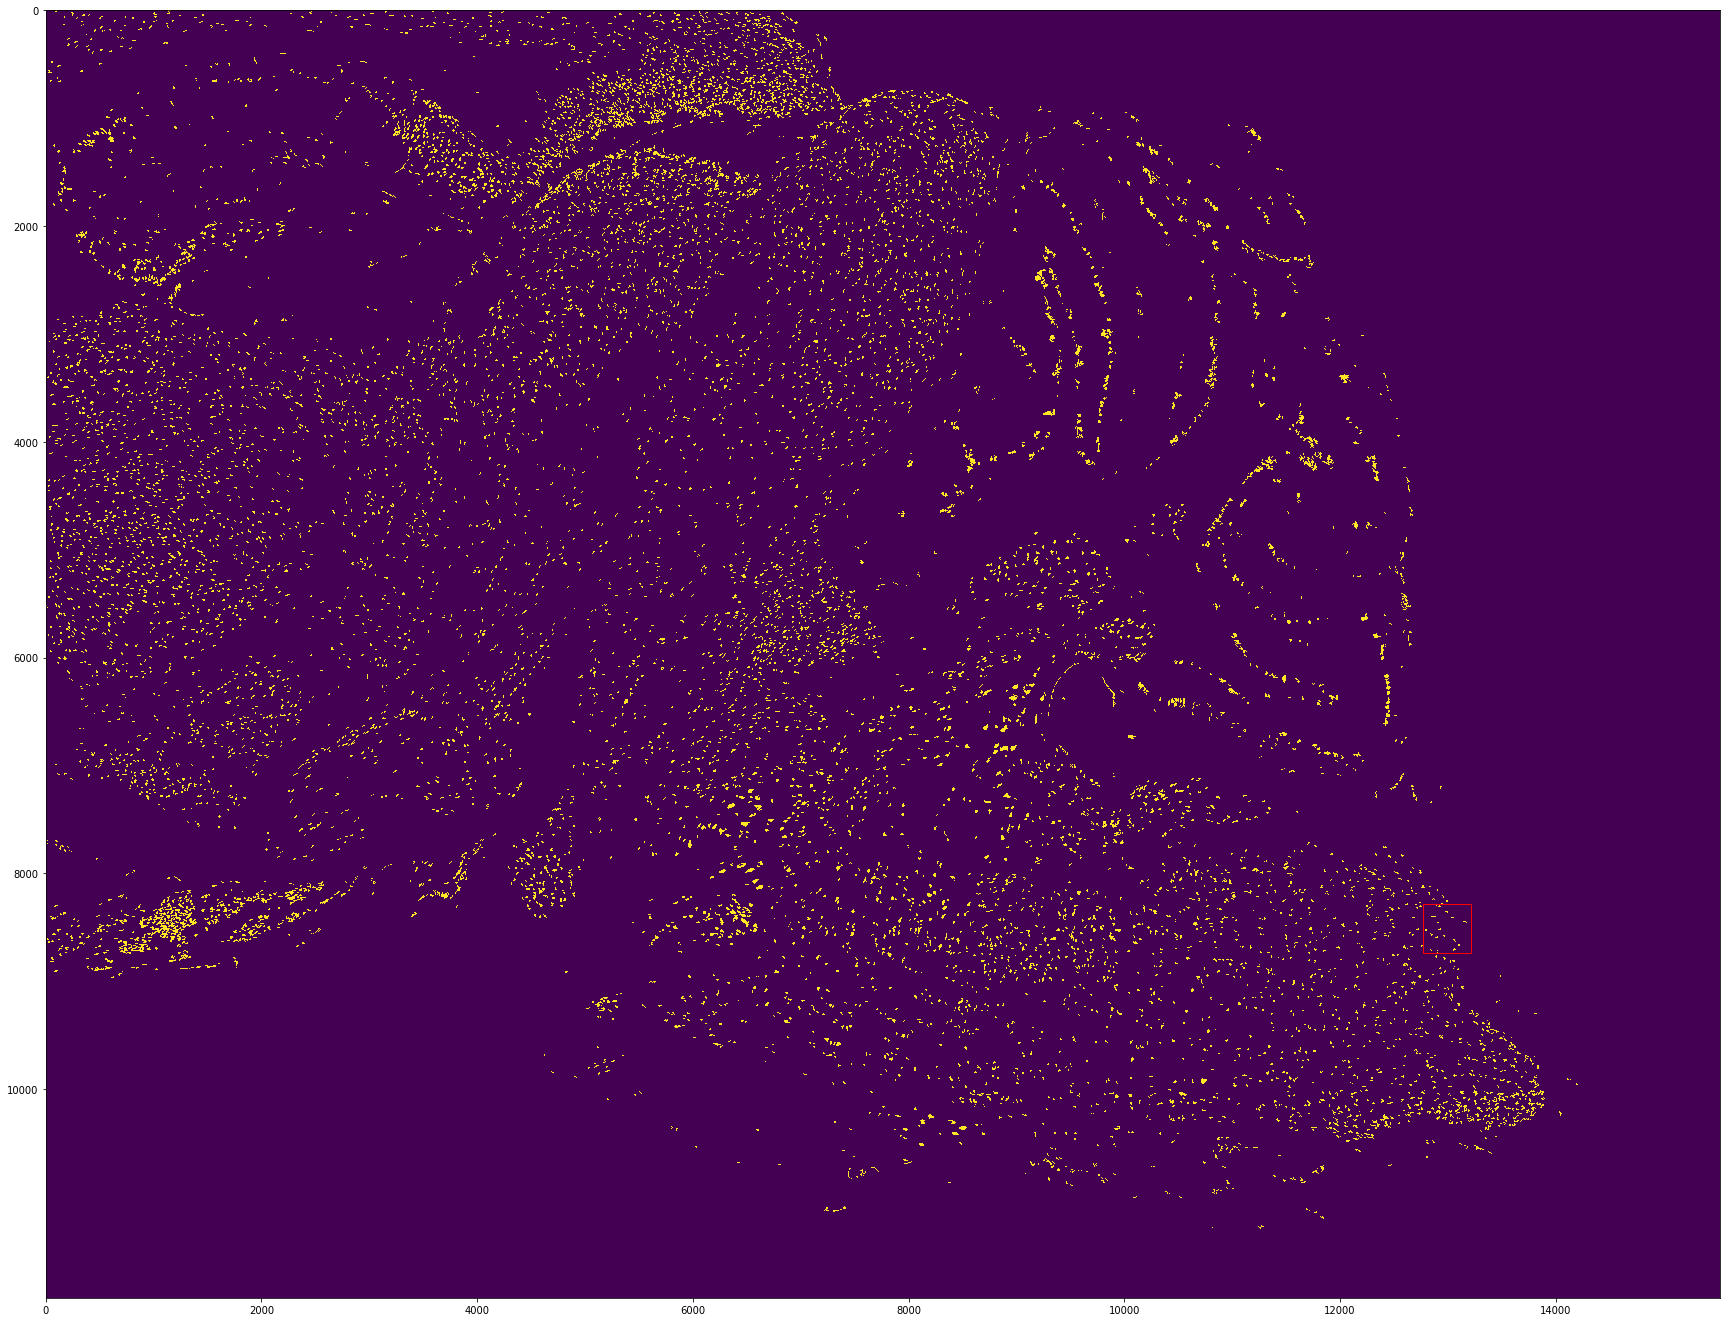

In [191]:
fun_image_overlay_square(im_label[section]>0, box_centroid=patch_center_pixel_location[patchID][::-1], width=patch_size,figsize=(30,30))

In [197]:
# List of patchID that have high average region matching score
tmpImage_dic = []
tmpHighAvgRegSimPID = patch_map[avg_vis_map>0.80];
# tmpHighAvgRegSimPID = patch_in_Sp5C
for tmpPatchID in tmpHighAvgRegSimPID:
    tmpImage_dic.append(fun_crop_images_2dInput(im_label[tmpSec], contour=patch_contour[tmpPatchID],im0max=im0max,im1max=im1max))

In [198]:
len(tmpHighAvgRegSimPID)

1116

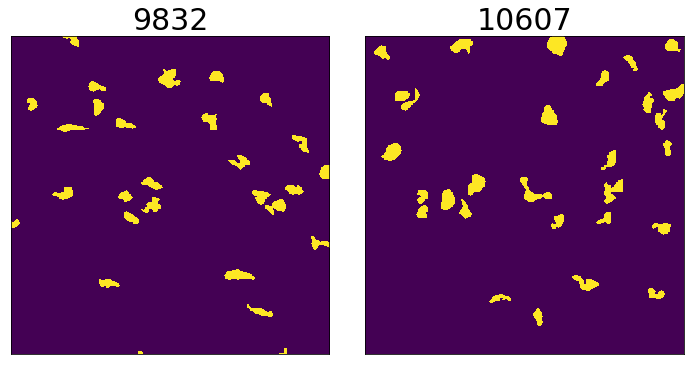

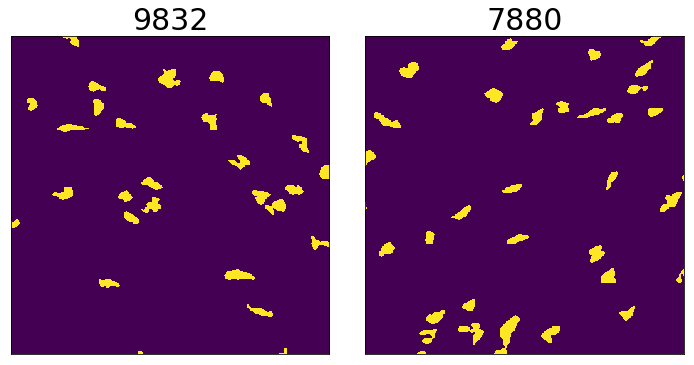

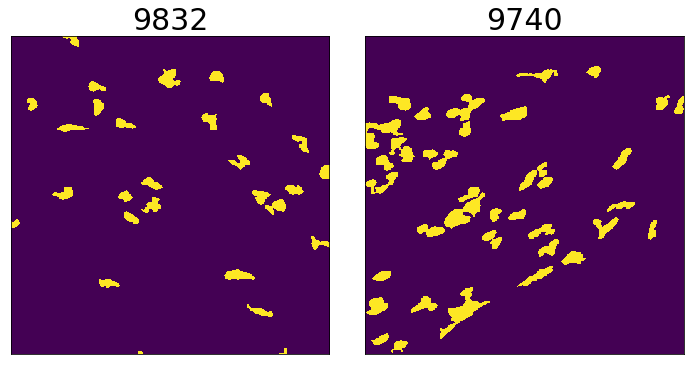

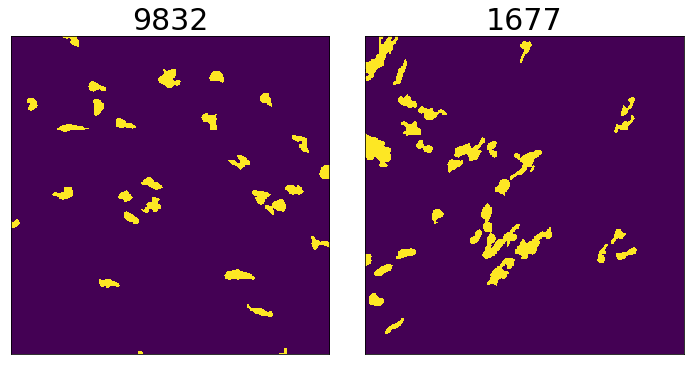

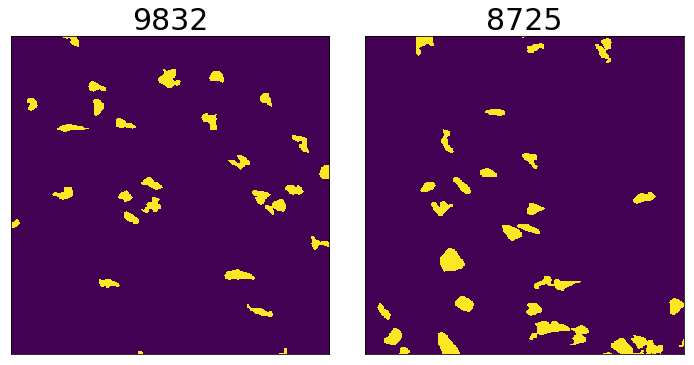

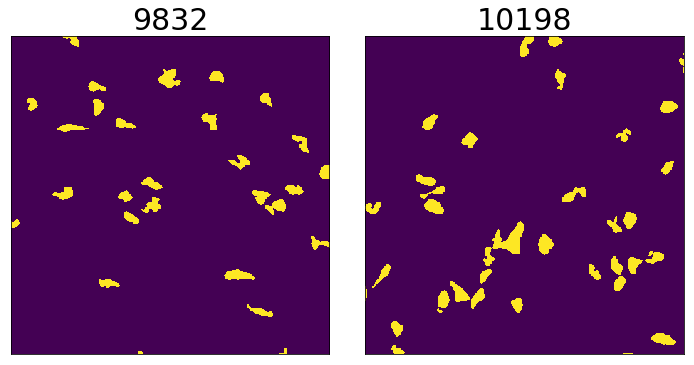

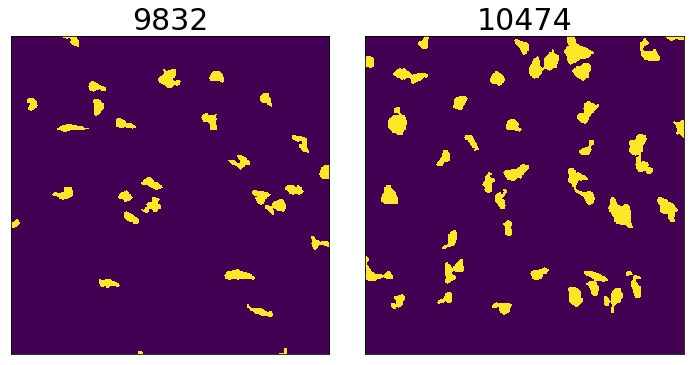

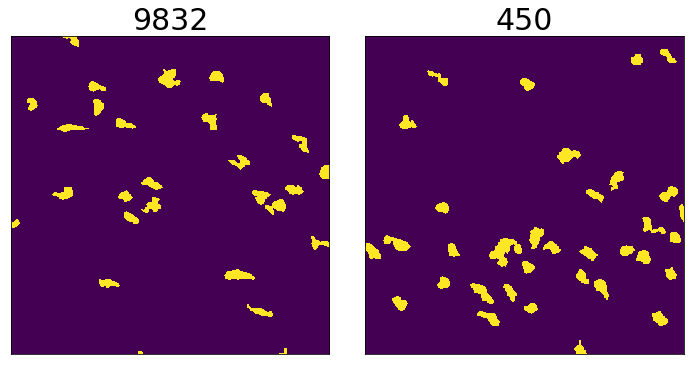

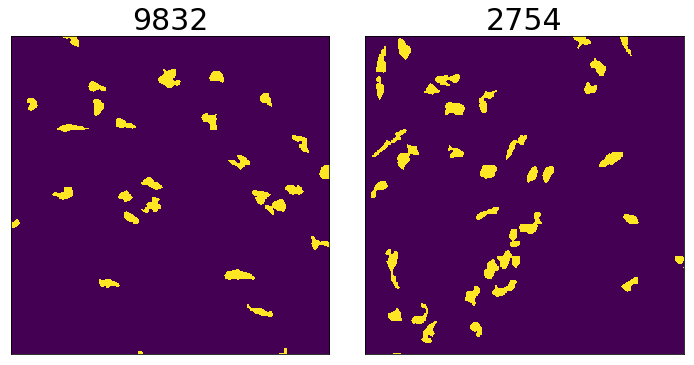

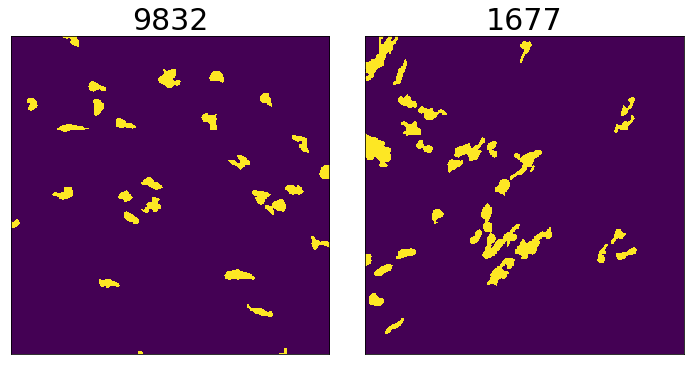

In [209]:
for tmpPID in np.random.choice(tmpHighAvgRegSimPID,10):
    display_images_in_grids([fun_crop_images_2dInput(im_label[section]>0, patch_contour[patchID], im0max=im0max, im1max=im1max), fun_crop_images_2dInput(im_label[tmpSec]>0, patch_contour[tmpPID], im0max=im0max, im1max=im1max)], nc=2,titles=[patchID, tmpPID])


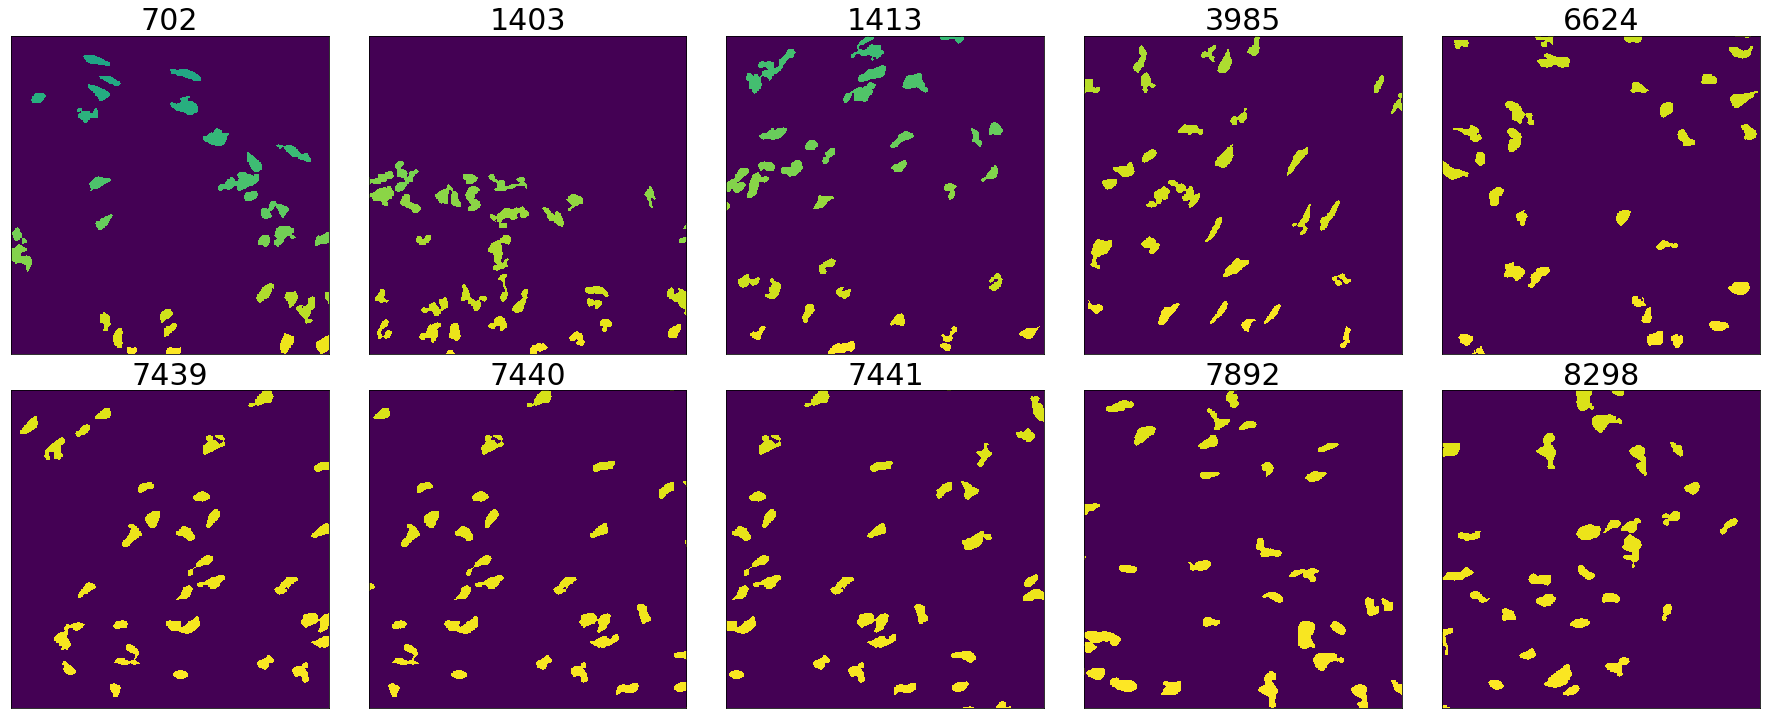

In [186]:
display_images_in_grids(tmpImage_dic,nc=5,titles=tmpHighAvgRegSimPID)

In [199]:
tmpHighAvgRegSimPID

array([    6,     7,    30, ..., 12405, 12536, 12537], dtype=int16)

In [140]:
patch_center_pixel_location[scan_patchID]

array([ 672, 2576])

In [212]:
# scan_patchID = scan_patchID_list[0]
scan_patchID = 1677
# Get blob props in patches by pologen. Alternatively, can use crop image, but require storing the image in the RAM
tempBlobInside = fun_blobs_in_polygen( blob_prop_dic[tempSec]['centroid'], patch_contour[scan_patchID],coor_order='cr')

tempBlobInsideIndex = np.where(tempBlobInside)[0]
temp_num_blob = len(tempBlobInsideIndex)
temp_weight_sim_matrix = np.zeros([num_current_blob, temp_num_blob], dtype=np.float16)
for tmp_current_blobID_idx in range(len(current_blobID_list)):
    temp_curr_blob_props = {}
    for tempProp in prop:
        temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][current_blobID_list[tmp_current_blobID_idx]]

    if temp_num_blob:
        temp_sim = {}
        for temp_prop in prop_for_comparison:
              temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))
        temp_weight_sim_matrix[tmp_current_blobID_idx,:] = np.dot(temp_sim_matrix,compare_weight)

In [216]:
tempBlobInsideIndex

array([1539, 1565, 1596, 1658, 1664, 1680, 1700, 1709, 1721, 1738, 1746,
       1748, 1761, 1783, 1833, 1871, 1880, 1919, 1926, 1927, 1946, 1953,
       1955, 1969, 1977, 1988, 2028, 2054])

In [217]:
np.shape(temp_weight_sim_matrix)

(29, 28)

In [221]:
temp_weight_sim_matrix

array([[ 0.39648438,  0.78955078,  0.81005859,  0.72509766,  0.73730469,
         0.60839844,  0.79101562,  0.65966797,  0.32568359,  0.51220703,
         0.69384766,  0.77587891,  0.5078125 ,  0.89892578,  0.84619141,
         0.41162109,  0.87011719,  0.46264648,  0.79003906,  0.78076172,
         0.73828125,  0.81445312,  0.82275391,  0.83251953,  0.52246094,
         0.859375  ,  0.83691406,  0.72363281],
       [ 0.33178711,  0.75      ,  0.67480469,  0.6640625 ,  0.76806641,
         0.51464844,  0.65820312,  0.61523438,  0.35205078,  0.39428711,
         0.76708984,  0.83007812,  0.41430664,  0.71777344,  0.71289062,
         0.3996582 ,  0.87158203,  0.36938477,  0.84667969,  0.82714844,
         0.80419922,  0.66210938,  0.64453125,  0.82470703,  0.42871094,
         0.70507812,  0.78027344,  0.75585938],
       [ 0.36450195,  0.80957031,  0.74414062,  0.75048828,  0.77197266,
         0.63183594,  0.79980469,  0.69287109,  0.35913086,  0.52685547,
         0.81201172,  0.7783

In [219]:
fun_region_similarity_v2(temp_weight_sim_matrix)

0.81066680372807021

In [220]:
fun_region_similarity_v1(temp_weight_sim_matrix)

23.10400390625

In [27]:
score_matrix = temp_weight_sim_matrix.copy()

In [29]:
matrix_shape

(40, 0)

In [28]:
matrix_shape = np.shape(score_matrix);
axis_idx_0 = matrix_shape.index(min(matrix_shape))
axis_idx_1 = 1 - axis_idx_0
# matrix_shape.index(max(matrix_shape))
num_iteration = matrix_shape[axis_idx_0]
region_similarity = 0;

### Region Comparison

In [470]:
for iterIdx in range(num_iteration):
#     print(np.shape(score_matrix))
    max_pos = tuple(np.argwhere(score_matrix==np.max(score_matrix))[0].tolist())
    region_similarity += score_matrix[max_pos]
    score_matrix = np.delete(score_matrix, (max_pos[axis_idx_1]), axis=axis_idx_1)
    score_matrix = np.delete(score_matrix, (max_pos[axis_idx_0]), axis=axis_idx_0)

(40, 40)
(39, 39)
(38, 38)
(37, 37)
(36, 36)
(35, 35)
(34, 34)
(33, 33)
(32, 32)
(31, 31)
(30, 30)
(29, 29)
(28, 28)
(27, 27)
(26, 26)
(25, 25)
(24, 24)
(23, 23)
(22, 22)
(21, 21)
(20, 20)
(19, 19)
(18, 18)
(17, 17)
(16, 16)
(15, 15)
(14, 14)
(13, 13)
(12, 12)
(11, 11)
(10, 10)
(9, 9)
(8, 8)
(7, 7)
(6, 6)
(5, 5)
(4, 4)
(3, 3)
(2, 2)
(1, 1)


In [400]:
np.shape(score_matrix)

(26, 21)

In [31]:
def fun_region_similarity_v1(score_matrix):
    matrix_shape = np.shape(score_matrix);
    axis_idx_0 = matrix_shape.index(min(matrix_shape))
    axis_idx_1 = 1 - axis_idx_0
    num_iteration = matrix_shape[axis_idx_0]
    region_similarity = 0;
    
    for iterIdx in range(num_iteration):
        max_pos = tuple(np.argwhere(score_matrix==np.max(score_matrix))[0].tolist())
        region_similarity += score_matrix[max_pos]
        score_matrix = np.delete(score_matrix, (max_pos[axis_idx_1]), axis=axis_idx_1)
        score_matrix = np.delete(score_matrix, (max_pos[axis_idx_0]), axis=axis_idx_0)
    return region_similarity

In [34]:
def fun_region_similarity_v2(score_matrix):
    matrix_shape = np.shape(score_matrix);
    avg_blobs = max(np.mean(matrix_shape),1);
    axis_idx_0 = matrix_shape.index(min(matrix_shape))
    axis_idx_1 = 1 - axis_idx_0
    num_iteration = matrix_shape[axis_idx_0]
    region_similarity = 0;
    
    for iterIdx in range(num_iteration):
        max_pos = tuple(np.argwhere(score_matrix==np.max(score_matrix))[0].tolist())
        region_similarity += score_matrix[max_pos]
        score_matrix = np.delete(score_matrix, (max_pos[axis_idx_1]), axis=axis_idx_1)
        score_matrix = np.delete(score_matrix, (max_pos[axis_idx_0]), axis=axis_idx_0)
    return region_similarity/avg_blobs

In [156]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = 'Sp5C'
vertice_Sp5C_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_Sp5C = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


In [161]:
patch_in_Sp5C = np.where(fun_blobs_in_polygen(patch_center_pixel_location,contour_vertice_coor_array=vertice_Sp5C_dic[tmpSec]))[0]